In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae

from keras.models import Model
from keras.layers import Input, LSTM, GRU, SimpleRNN, Dense
import keras.backend as K
from tensorflow.keras.optimizers import SGD, Adam

#from keras.optimizers import SGD, Adam

In [3]:
# make the original data
series = np.sin(0.1*np.arange(200)) + np.random.randn(200)*0.1

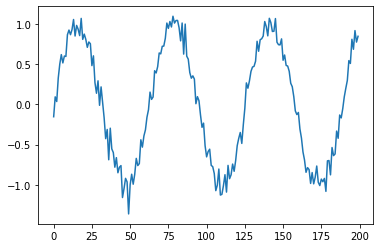

In [4]:
# plot it
plt.plot(series)
plt.show()

In [5]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X)
Y = np.array(Y)
N = len(X)

In [6]:
# split into train and test
Xtrain, Ytrain = X[:-N//2], Y[:-N//2]
Xtest, Ytest = X[-N//2:], Y[-N//2:]

In [7]:
### try autoregressive model
model = LinearRegression()
model.fit(Xtrain, Ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [8]:
# get model predictions
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

In [9]:
# print R^2
print("linear train r^2:", model.score(Xtrain, Ytrain))
print("linear test r^2:", model.score(Xtest, Ytest))

linear train r^2: 0.9716404306253464
linear test r^2: 0.9738943833149661


In [10]:
# print MAE
print("linear train mae:", mae(Ytrain, Ptrain))
print("linear test mae:", mae(Ytest, Ptest))

linear train mae: 0.09379188233457439
linear test mae: 0.09405158634750281


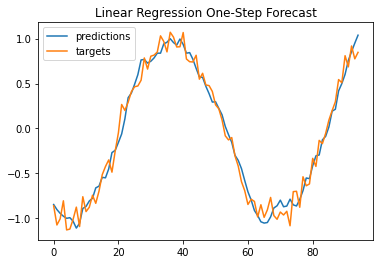

In [11]:
# One-Step Forecast
plt.plot(Ptest, label='predictions')
plt.plot(Ytest, label='targets')
plt.title("Linear Regression One-Step Forecast")
plt.legend()
plt.show()

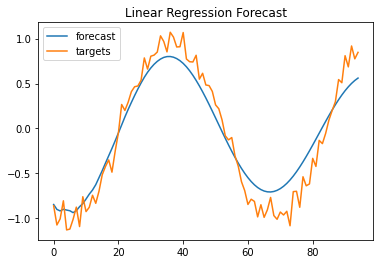

In [12]:
# Real forecast
forecast = []
input_ = Xtest[0]
while len(forecast) < len(Ytest):
  x = np.expand_dims(input_, 0)
  f = model.predict(x)
  forecast.append(f[0])
  # make a new input with the latest forecast
  input_ = np.concatenate([input_[1:], f])

plt.plot(forecast, label='forecast')
plt.plot(Ytest, label='targets')
plt.title("Linear Regression Forecast")
plt.legend()
plt.show()

In [13]:
# Make inputs N x T x D
inputs_train = Xtrain.reshape(-1, T, 1)
inputs_test = Xtest.reshape(-1, T, 1)

In [14]:
# make the RNN
i = Input(shape=(T, D))
x = SimpleRNN(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [15]:
# train the RNN
r = model.fit(
  inputs_train, Ytrain,
  batch_size=32,
  epochs=80,
  validation_data=(inputs_test, Ytest),
)

Epoch 1/80
3/3 [==============================] - 4s 152ms/step - loss: 0.2777 - val_loss: 0.0538
Epoch 2/80
3/3 [==============================] - 0s 26ms/step - loss: 0.0632 - val_loss: 0.0537
Epoch 3/80
3/3 [==============================] - 0s 30ms/step - loss: 0.0405 - val_loss: 0.0222
Epoch 4/80
3/3 [==============================] - 0s 30ms/step - loss: 0.0367 - val_loss: 0.0365
Epoch 5/80
3/3 [==============================] - 0s 27ms/step - loss: 0.0419 - val_loss: 0.0254
Epoch 6/80
3/3 [==============================] - 0s 25ms/step - loss: 0.0372 - val_loss: 0.0244
Epoch 7/80
3/3 [==============================] - 0s 27ms/step - loss: 0.0400 - val_loss: 0.0254
Epoch 8/80
3/3 [==============================] - 0s 27ms/step - loss: 0.0359 - val_loss: 0.0261
Epoch 9/80
3/3 [==============================] - 0s 25ms/step - loss: 0.0318 - val_loss: 0.0213
Epoch 10/80
3/3 [==============================] - 0s 29ms/step - loss: 0.0278 - val_loss: 0.0213
Epoch 11/80
3/3 [===========

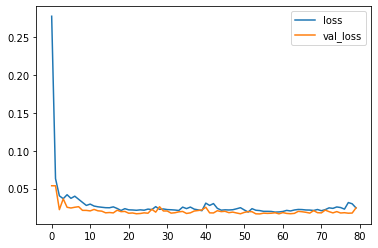

In [16]:
# plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [17]:
# Get flattened predictions
Ptrain = model.predict(inputs_train).flatten()
Ptest = model.predict(inputs_test).flatten()

In [18]:
print("rnn train mae:", mae(Ytrain, Ptrain))
print("rnn test mae:", mae(Ytest, Ptest))

rnn train mae: 0.11749238729122738
rnn test mae: 0.12296161035563179


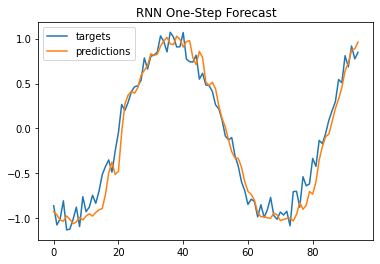

In [19]:
# plot predictions vs targets
plt.plot(Ytest, label='targets')
plt.plot(Ptest, label='predictions')
plt.title("RNN One-Step Forecast")
plt.legend()
plt.show()

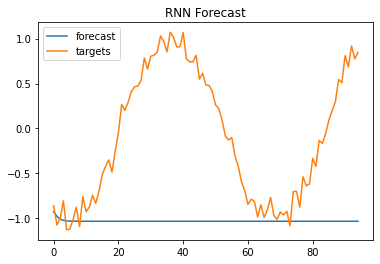

In [20]:
# Real forecast
forecast = []
input_ = Xtest[0]
while len(forecast) < len(Ytest):
  f = model.predict(input_.reshape(1, T, 1))[0,0]
  forecast.append(f)

  # make a new input with the latest forecast
  input_ = np.roll(input_, -1)
  input_[-1] = f

plt.plot(forecast, label='forecast')
plt.plot(Ytest, label='targets')
plt.title("RNN Forecast")
plt.legend()
plt.show()